In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

path = r"C:\Users\HP\OneDrive\Escritorio\David Guzzi\DiTella\MEC\Materias\2025\2025 1T\[MT10] Series de Tiempo\Clases prácticas\Práctica 1-20250419\var.xlsx"
df = pd.read_excel(path)
df.head()

,dateid01,dateid,fed_funds,inflation,un_rate
0,1947-01-01,1947-03-31 23:59:59.999,NaN,NaN,NaN
1,1947-04-01,1947-06-30 23:59:59.999,NaN,5.737548,NaN
2,1947-07-01,1947-09-30 23:59:59.999,NaN,7.118936,NaN
3,1947-10-01,1947-12-31 23:59:59.999,NaN,8.188125,NaN
4,1948-01-01,1948-03-31 23:59:59.999,NaN,4.503751,3.733333


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   219 non-null    datetime64[ns]
 1   dateid     219 non-null    datetime64[ns]
 2   fed_funds  189 non-null    float64       
 3   inflation  218 non-null    float64       
 4   un_rate    215 non-null    float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 8.7 KB


In [16]:
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.info()

In [3]:
df['dateid01'] = pd.to_datetime(df['dateid01'])
df['dateidQ'] = df['dateid01'].dt.to_period('Q')
df.sort_values(by=['dateid01'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   219 non-null    datetime64[ns]
 1   dateid     219 non-null    datetime64[ns]
 2   fed_funds  189 non-null    float64       
 3   inflation  218 non-null    float64       
 4   un_rate    215 non-null    float64       
 5   dateidQ    219 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(3), period[Q-DEC](1)
memory usage: 10.4 KB


In [4]:
df_f = df[(df['dateidQ']>='1960Q1')&(df['dateidQ']<='2000Q4')]
df_f.reset_index(drop=True, inplace=True)
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dateid01   164 non-null    datetime64[ns]
 1   dateid     164 non-null    datetime64[ns]
 2   fed_funds  164 non-null    float64       
 3   inflation  164 non-null    float64       
 4   un_rate    164 non-null    float64       
 5   dateidQ    164 non-null    period[Q-DEC] 
dtypes: datetime64[ns](2), float64(3), period[Q-DEC](1)
memory usage: 7.8 KB


In [67]:
df_f = df_f[['dateid', 'fed_funds', 'inflation', 'un_rate']].copy()
df_f.set_index('dateid', inplace=True)

from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f, freq='QE')
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Apr, 2025
Time:                     20:09:31
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.50944
Nobs:                     160.000    HQIC:                  -2.95464
Log likelihood:          -381.369    FPE:                  0.0384676
AIC:                     -3.25902    Det(Omega_mle):       0.0304310
--------------------------------------------------------------------
Results for equation fed_funds
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.540692         0.333943            1.619           0.105
L1.fed_funds         0.946091         0.091146           10.380           0.000
L1.inflation         0.068137         0.073169            0.

In [7]:
import os	
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import graph_objects as go

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
from statsmodels.tsa.api import VARMAX

logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(message)s")


class VarModel:
    """
    A class to fit and analyze VAR (and extended) models, replicating EViews diagnostics.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing multiple endogenous variables (time series).
    lags : int, optional
        Number of lags for the VAR model. Default=1.
    exog : pd.DataFrame or None, optional
        Optional exogenous regressors.
    model_type : str, optional
        'VAR', 'SVAR', 'VECM'. Determines which type of model to fit. Default='VAR'.
    svar_ident : str, optional
        Identification scheme for SVAR (e.g. 'A' or 'B') if `model_type='SVAR'`.
    """

    def __init__(self, data, lags=1, exog=None, model_name="VAR", svar_ident="A"):
        self.data = data
        self.lags = lags
        self.exog = exog
        self.model_name = model_name.upper()
        self.svar_ident = svar_ident

        # Fitted model result placeholder
        self.fitted_model = None

        # For VECM specifically
        self.vecm_rank = None  # Will be determined if model_type='VECM'
        self.vecm_trend = None
        self.vecm_results = None


    def fit(self, deterministic="nc", coint_rank=None):
        """
        Fit the model (VAR, SVAR, or VECM) with specified parameters.

        Parameters
        ----------
        deterministic : str
            Deterministic term specification for VECM (e.g., 'nc', 'co', 'ci', etc.).
            Only used if model_type='VECM'.
        coint_rank : int, optional
            Number of cointegrating relationships (rank). Only used if model_type='VECM'.

        Notes
        -----
        - If model_type='VAR', uses `VAR(self.data, exog=self.exog).fit(self.lags)`.
        - If model_type='SVAR', first fits a standard VAR, then applies structural identification
          using `SVAR(fitted_model, svar_type=self.svar_ident)`.
        - If model_type='VECM', uses `VECM(self.data, k_ar_diff=self.lags, deterministic=deterministic,
          rank=coint_rank, ...)`.
        """
        logging.info(f"Fitting {self.model_name} model with {self.lags} lags.")

        if self.model_name == "VAR":
            # Fit a standard VAR
            var_mod = VAR(self.data, exog=self.exog)
            self.fitted_model = var_mod.fit(self.lags)
            logging.info("VAR model fitted successfully.")

        elif self.model_name == "SVAR":
            # First fit standard VAR
            var_mod = VAR(self.data, exog=self.exog)
            base_fit = var_mod.fit(self.lags)
            # Then create SVAR with identification
            svar_mod = SVAR(base_fit, svar_type=self.svar_ident)
            self.fitted_model = svar_mod.fit()
            logging.info("SVAR model fitted successfully with identification=%s", self.svar_ident)

        elif self.model_name == "VECM":
            # VECM requires cointegration rank. If user didn't specify, attempt coint test
            if coint_rank is None:
                # Attempt to guess from Johansen if not provided
                logging.info("Cointegration rank not specified; attempting Johansen test.")
                joh_results = coint_johansen(self.data, det_order=0, k_ar_diff=self.lags)
                # Heuristic to pick rank: number of significant eigenvalues
                trace_stat = joh_results.lr1
                crit_vals = joh_results.cvt[:, 1]  # 5% critical values
                rank = sum(trace_stat > crit_vals)
                coint_rank = rank
                logging.info("Inferred cointegration rank from Johansen test: %d", coint_rank)

            self.vecm_rank = coint_rank
            self.vecm_trend = deterministic
            vecm_mod = VECM(self.data, k_ar_diff=self.lags, deterministic=deterministic, rank=coint_rank, exog=self.exog)
            self.vecm_results = vecm_mod.fit()
            self.fitted_model = self.vecm_results  # store for consistency
            logging.info("VECM fitted successfully with rank=%d, deterministic=%s", coint_rank, deterministic)
        else:
            raise ValueError(f"Unknown model_type={self.model_name}")


    def display_estimation(self):
        """
        Display EViews-like output table with coefficients, standard errors, t-stats, etc.
        Also prints key fit stats (AIC, SC, log-likelihood, etc.) depending on model_type.
        """
        if self.fitted_model is None:
            print("No fitted model available. Please call .fit() first.")
            return

        print("==================================================")
        print(f"          {self.model_name} Estimation Results")
        print("==================================================")

        # Standard VAR results
        if self.model_name in ["VAR", "SVAR"]:
            print(f"Lags: {self.lags}")
            print(f"Number of observations: {self.fitted_model.nobs}")
            print(f"AIC: {self.fitted_model.aic:.3f}")
            print(f"BIC: {self.fitted_model.bic:.3f}")
            print(f"FPE: {self.fitted_model.fpe:.3e}")
            print(f"Log-likelihood: {self.fitted_model.llf:.3f}")
            print("--------------------------------------------------")

            # Coefficients per equation
            for eqn_name in self.fitted_model.names:
                print(f"\nEquation: {eqn_name}")
                coefs = self.fitted_model.params[eqn_name]
                stderrs = self.fitted_model.stderr[eqn_name]
                tvals = coefs / stderrs
                # p-values not always directly accessible, we can approximate
                # or rely on self.fitted_model.pvalues if available
                coef_table_header = f"{'Variable':<20} {'Coef':>12} {'Std.Err':>12} {'t-Stat':>12}"
                print(coef_table_header)
                print("-" * len(coef_table_header))
                for param_name, coef_val in coefs.items():
                    std_err = stderrs.get(param_name, np.nan)
                    tval = tvals.get(param_name, np.nan)
                    print(f"{param_name:<20} {coef_val:>12.4f} {std_err:>12.4f} {tval:>12.4f}")

        elif self.model_name == "VECM":
            print(f"Lags (AR diff): {self.lags}")
            print(f"Cointegration rank: {self.vecm_rank}")
            print("--------------------------------------------------")
            params = self.vecm_results.params  # The short-run params
            alpha = self.vecm_results.alpha    # The speed of adjustment (long-run)
            beta = self.vecm_results.beta      # Cointegration vectors

            print("Short-run coefficients (params):")
            print(params)
            print("\nAlpha (speed of adjustment):")
            print(alpha)
            print("\nBeta (cointegration vectors):")
            print(beta)

        print("==================================================")


    def residual_correlograms(self, max_lag=24, output_dir=None, filename="var_resid_correl.png", show_plot=True):
        """
        Plot the autocorrelation (AC) for each equation's residual in a single figure
        with horizontal bars, EViews style. All variables shown in the same figure,
        either stacked vertically or side-by-side.

        Returns
        -------
        dict of pd.DataFrame
            AC DataFrames for each variable: { var_name: DataFrame of [Lag, AC] }.
        """
        if self.fitted_model is None:
            raise ValueError("VAR model not fitted.")

        residuals = self.fitted_model.resid
        var_names = list(residuals.columns)
        n_vars = len(var_names)

        # We'll create a figure with n_vars rows, 1 column, each row is a horizontal bar chart
        fig_height = max(4, n_vars * 2.5)
        fig, axes = plt.subplots(n_vars, 1, figsize=(8, fig_height), sharex=False)
        if n_vars == 1:
            axes = [axes]  # ensure it's a list

        df_dict = {}

        for i, var_name in enumerate(var_names):
            ax = axes[i]
            series = residuals[var_name].dropna()
            ac_vals = acf(series, nlags=max_lag, fft=False)

            n = len(series)
            se = 1.0 / np.sqrt(n)
            # For alpha=0.05 => ~1.96
            bound = 1.96 * se

            # Build a DataFrame
            data_rows = []
            for lag in range(1, max_lag+1):
                data_rows.append({"Lag": lag, "AC": ac_vals[lag]})
            ac_df = pd.DataFrame(data_rows)
            df_dict[var_name] = ac_df

            # Reverse so lag=1 is top
            rev_df = ac_df.iloc[::-1].reset_index(drop=True)

            # Horizontal bar chart
            ax.barh(rev_df.index, rev_df["AC"], color="#c6d9f0", edgecolor="black")
            ax.axvline(bound, color="grey", linestyle="--")
            ax.axvline(-bound, color="grey", linestyle="--")

            ax.invert_yaxis()
            ax.set_xlim([-1.0, 1.0])
            ax.set_ylabel(f"{var_name}  (Lag)")  # or just var_name
            ax.set_yticks(rev_df.index)
            ax.set_yticklabels(rev_df["Lag"].astype(str))
            # If you want an x-axis label for just the last subplot:
            if i == n_vars - 1:
                ax.set_xlabel("Autocorr.")
            else:
                ax.set_xlabel("")

            ax.set_title(f"{var_name}", fontsize=10, pad=10)

        fig.suptitle(f"{self.model_name} - Residual Correlograms", fontsize=11, y=0.96)
        plt.tight_layout()

        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            outfile = os.path.join(output_dir, filename)
            plt.savefig(outfile, dpi=150, bbox_inches="tight")

        if show_plot:
            plt.show()

        return df_dict
    

    def portmanteau_test(self, max_lag=12):
        """
        Perform Portmanteau (Q) test for autocorrelation in VAR residuals up to `max_lag`.
        Return or print a table with Q-Stat, p-values, etc.
        """
        if self.model_name == "VECM":
            logging.warning("Portmanteau tests are typically for VAR residuals. Will run on short-run VECM residuals.")
        if self.fitted_model is None:
            logging.error("No fitted model to run portmanteau test. Call fit() first.")
            return

        if self.model_name in ["VAR", "SVAR"]:
            results = sm.stats.acorr_ljungbox(self.fitted_model.resid, lags=[max_lag], return_df=True)
            print("Portmanteau (Ljung-Box) Test:")
            print(results)
        elif self.model_name == "VECM":
            results = sm.stats.acorr_ljungbox(self.vecm_results.resid, lags=[max_lag], return_df=True)
            print("Portmanteau (Ljung-Box) Test on VECM residuals:")
            print(results)


    def johansen_cointegration_test(self, det_order=0, k_ar_diff=1):
        """
        Conduct Johansen cointegration test with user-specified deterministic trend assumptions
        and lag differences. This is helpful even if not strictly doing VECM.
        """
        logging.info("Running Johansen cointegration test with det_order=%d, k_ar_diff=%d.", det_order, k_ar_diff)
        results = coint_johansen(self.data, det_order=det_order, k_ar_diff=k_ar_diff)
        # Print or return results
        print("--------------------------------------------------")
        print("Johansen Cointegration Test Results")
        print("--------------------------------------------------")
        print(f"Eigenvalues:\n{results.eig}")
        print(f"\nTrace Statistics:\n{results.lr1}")
        print(f"Critical Values (trace):\n{results.cvt}")
        print(f"\nMax-Eigenvalue Statistics:\n{results.lr2}")
        print(f"Critical Values (max-eig):\n{results.cvm}")
        print("--------------------------------------------------")


    def impulse_response(self, steps=10, orth=True, impulselist=None, method='default'):
        """
        Compute IRF for the fitted model. Can do advanced bootstrapping or Monte Carlo if desired.

        Parameters
        ----------
        steps : int
            Number of periods for impulse response.
        orth : bool
            If True, compute orthogonalized IRF via Cholesky decomposition.
        impulselist : list of str, optional
            Variables for which impulses are computed. If None, all endogenous variables.
        method : str
            'default' for standard IRF, 'bootstrap' or 'mc' for advanced uncertainty analysis.

        Returns
        -------
        object
            IRF results or a custom structure. This is simplified; actual usage
            might rely on statsmodels or a custom IRF approach.
        """
        if self.fitted_model is None:
            logging.error("No fitted model for IRF. Call fit() first.")
            return None

        # For standard VAR or SVAR
        if self.model_name in ["VAR", "SVAR"]:
            irf = self.fitted_model.irf(steps=steps)
            if method.lower() == 'bootstrap':
                logging.info("Running bootstrap-based IRF confidence intervals.")
                # statsmodels IRF object supports bootstrap
                irf_plot = irf.plot(stderr=True, orth=orth, impulse=impulselist, plot_stderr=True, repl=1000)
                return irf_plot
            else:
                # default or 'mc'
                irf_plot = irf.plot(orth=orth, impulse=impulselist)
                return irf_plot

        elif self.model_name == "VECM":
            logging.warning("IRF for VECM not fully supported in statsmodels. "
                            "Implement custom approach if needed.")
            # We might do a custom approach or rely on the FEVD from the companion VAR representation.


    def white_heteroskedasticity_test(self):
        """
        Placeholder for White's test for heteroskedasticity in each VAR equation residual.
        Typically used for univariate regressions, but can be adapted for each equation in the system.

        Returns
        -------
        dict
            Dictionary of test statistics per equation.
        """
        if self.fitted_model is None:
            logging.error("No fitted model. Call fit() first.")
            return {}

        if self.model_name not in ["VAR", "SVAR"]:
            logging.warning("White test primarily relevant for (S)VAR. For VECM, adapt as needed.")

        # For each equation in residuals, run a White test as if it were a standard OLS regression:
        # This is a simplified approach, can be improved for true multivariate white test logic.
        residuals = self.fitted_model.resid
        results = {}
        for eqn_name in residuals.columns:
            eq_resid = residuals[eqn_name]
            # Build the design matrix (the original regressors) - here, we assume a standard approach
            # In a real scenario, we'd reconstruct the design from self.fitted_model.
            # We'll do a placeholder: y = alpha + Beta1 * y_{t-1} + ...
            # Then run White test with statsmodels. For illustration, we skip actual regressor retrieval.
            # A real implementation would require a full OLS object with exog expansions.
            results[eqn_name] = "White test placeholder"

        return results
    

    def forecast(self, steps=5, method='static', plot='none'):
        """
        Produce either a static or dynamic forecast of the fitted VAR model.

        **Static Forecast (One-Step Ahead)**:
            - For each forecasted period, we use the actual data if it's within the sample
              or newly available. Minimizes accumulation of forecast errors.

        **Dynamic Forecast (Multi-Step Ahead)**:
            - Starting from the forecast origin, we use only forecasted values for future lags.
            - Errors can accumulate over the forecast horizon.

        Implementation
        -------------
        - statsmodels' VARResults provides `.forecast()` which requires the last `p` observations
          to generate forecasts. For dynamic, we simply feed the model's own predictions once
          we step beyond the available data. For truly 'in-sample static' forecasts,
          we can iteratively incorporate actual data if it's in-sample.

        Parameters
        ----------
        steps : int
            Number of steps to forecast.
        method : {'static', 'dynamic'}
            Forecasting approach.
        plot : {'none', 'forecast', 'forecast_and_actuals'}
            If 'forecast' or 'forecast_and_actuals', plots the forecast vs. time.

        Returns
        -------
        pd.DataFrame
            DataFrame of forecasted values for each endogenous variable.
        """
        if self.fitted_model is None:
            logging.error("No fitted VAR model. Call `fit()` first.")
            return pd.DataFrame()

        # Retrieve last `lags` observations
        endog_vals = self.data.values
        p = self.fitted_model.k_ar
        last_obs = endog_vals[-p:, :]  # shape: (p, k_endog)

        # Implementation detail:
        # - For 'dynamic' forecasting, we just rely on .forecast() from the model
        #   over the entire horizon, substituting predicted values after the origin.
        # - For 'static' in-sample, we can do iterative one-step ahead:
        #   if the forecast horizon is within the sample, we can progressively
        #   use actual data. If out-of-sample, we revert to typical forecast approach.

        forecasts = []
        if method.lower() == 'dynamic':
            forecast_vals = self.fitted_model.forecast(last_obs, steps=steps)
            idx_forecast = pd.date_range(start=self.data.index[-1], periods=steps+1, freq=self._infer_freq())[1:]
            df_forecast = pd.DataFrame(forecast_vals, columns=self.fitted_model.names, index=idx_forecast)
            forecasts = df_forecast
        else:  # static
            # We'll simulate a "rolling" one-step ahead approach.
            # If we remain in-sample, we can substitute actual data. For out-of-sample, we use forecast.
            # For simplicity, assume all forecast steps are out-of-sample for demonstration.
            # A more advanced approach could check if part of the forecast horizon overlaps the sample.
            obs_seq = last_obs.copy()
            forecast_out = []
            for step in range(steps):
                step_forecast = self.fitted_model.forecast(obs_seq, steps=1)[0]  # 1D array
                forecast_out.append(step_forecast)
                # shift obs_seq up by one and place the newly forecasted row at the bottom
                obs_seq = np.vstack([obs_seq[1:], step_forecast])

            idx_forecast = pd.date_range(start=self.data.index[-1], periods=steps+1, freq=self._infer_freq())[1:]
            df_forecast = pd.DataFrame(forecast_out, columns=self.fitted_model.names, index=idx_forecast)
            forecasts = df_forecast

        # Plot if requested
        if plot in ("forecast", "forecast_and_actuals"):
            plt.figure(figsize=(10, 5))
            for col in self.fitted_model.names:
                if plot == "forecast_and_actuals":
                    plt.plot(self.data.index, self.data[col], label=f"{col} Actual", alpha=0.7)
                plt.plot(forecasts.index, forecasts[col], label=f"{col} Forecast")
            plt.title(f"{self.model_name} - {method.capitalize()} Forecast")
            plt.legend()
            plt.tight_layout()
            plt.show()

        return forecasts


    def _infer_freq(self):
        """Utility to try inferring frequency from the DataFrame index, default to 'D' (daily)."""
        freq = pd.infer_freq(self.data.index)
        if freq is None:
            freq = 'D'
        return freq

In [73]:
model = VarModel(df_f[['fed_funds', 'inflation', 'un_rate']], lags=4, model_name="VAR")
model.fit()
model.display_estimation()

INFO:Fitting VAR model with 4 lags.
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
INFO:VAR model fitted successfully.


          VAR Estimation Results
Lags: 4
Number of observations: 160
AIC: -3.259
BIC: -2.509
FPE: 3.847e-02
Log-likelihood: -381.369
--------------------------------------------------

Equation: fed_funds
Variable                     Coef      Std.Err       t-Stat
-----------------------------------------------------------
const                      0.5407       0.3339       1.6191
L1.fed_funds               0.9461       0.0911      10.3800
L1.inflation               0.0681       0.0732       0.9312
L1.un_rate                -1.6425       0.3476      -4.7255
L2.fed_funds              -0.3669       0.1215      -3.0197
L2.inflation               0.2265       0.0852       2.6568
L2.un_rate                 1.8244       0.5972       3.0548
L3.fed_funds               0.3392       0.1195       2.8384
L3.inflation              -0.1011       0.0865      -1.1676
L3.un_rate                -0.8537       0.6026      -1.4169
L4.fed_funds               0.0117       0.0916       0.1278
L4.inflation   

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Supongamos que df tiene las tres columnas: y1, y2, y3
# Y queremos un VAR con p rezagos
p = 4  # número de rezagos

# Crear las variables rezagadas
df_f = df_f[['fed_funds', 'inflation', 'un_rate']].copy()
df_lagged = pd.concat([df_f.shift(i) for i in range(1, p+1)], axis=1)
df_lagged.columns = [f'{col}_lag{i}' for i in range(1, p+1) for col in df_f.columns]

# DataFrame final: quitamos los primeros p registros (por el rezago)
df_model = pd.concat([df_f, df_lagged], axis=1).dropna()

# Variables endógenas (Y) y variables explicativas (X)
Y = df_model[df_f.columns]
X = df_model.drop(columns=df_f.columns)
X = sm.add_constant(X)  # agregar intercepto

In [10]:
results = {}

for col in Y.columns:
    model = sm.OLS(Y[col], X).fit()
    n = model.nobs  # número de observaciones
    k = model.df_model + 1  # número de parámetros (incluyendo intercepto)

    aic_manual = (2 * k - 2 * model.llf) / n
    bic_manual = (np.log(n) * k - 2 * model.llf) / n

    results[col] = {
        'R2': model.rsquared,
        'Adj_R2': model.rsquared_adj,
        'Sum_sq_resids': np.sum(model.resid ** 2),
        'SE_equation': np.sqrt(np.sum(model.resid ** 2) / model.df_resid),
        'F-statistic': model.fvalue,
        'LogLikelihood': model.llf,
        'AIC': aic_manual,
        'BIC': bic_manual,
        'Mean_dependent': np.mean(Y[col]),
        'SD_dependent': np.std(Y[col], ddof=1)
    }

pd.DataFrame(results)

,fed_funds,inflation,un_rate
R2,0.928300,0.854673,0.979647
Adj_R2,0.922447,0.842809,0.977985
Sum_sq_resids,114.993849,142.631282,7.530268
SE_equation,0.884461,0.985028,0.226332
F-statistic,158.600172,72.042499,589.612980
LogLikelihood,-200.606552,-217.837288,17.469289
AIC,2.670082,2.885466,-0.055866
BIC,2.919940,3.135324,0.193992
Mean_dependent,6.674417,3.935403,5.970208
SD_dependent,3.175985,2.484479,1.525413


In [11]:
from statsmodels.tsa.api import VAR

model_var = VAR(df_f)
var_result = model_var.fit(p)

# Log likelihood total del sistema
loglik_total = var_result.llf

# Número de parámetros
k_total = var_result.neqs * (var_result.neqs * p + 1)  # (número de coeficientes por ecuación) * (número de ecuaciones)

# Número de observaciones
n_obs = var_result.nobs

# AIC grupal
aic_var = (2 * k_total - 2 * loglik_total) / n_obs

# BIC grupal
bic_var = (np.log(n_obs) * k_total - 2 * loglik_total) / n_obs

In [17]:
def eviews_style_stats(var_result):
    """
    Emula exactamente la salida de EViews para un VAR de statsmodels.
    Calcula determinantes ajustados y no ajustados, log likelihood, AIC, BIC y número de coeficientes.
    """
    n_obs = var_result.nobs
    n_eqs = var_result.neqs
    p = var_result.k_ar

    # Número de parámetros estimados por ecuación
    k_per_eq = n_eqs * p + 1

    # Matriz de residuos
    resid = var_result.resid

    # Covarianza de residuos (ajustada y no ajustada)
    sigma_u_adj = (resid.T @ resid) / (n_obs - k_per_eq)
    sigma_u_unadj = (resid.T @ resid) / n_obs

    # Determinantes
    det_sigma_u_adj = np.linalg.det(sigma_u_adj)
    det_sigma_u = np.linalg.det(sigma_u_unadj)

    # Log-likelihood
    loglik = var_result.llf

    # Número total de parámetros
    k_total = n_eqs * (n_eqs * p + 1)

    # AIC y BIC
    aic_var = (2 * k_total - 2 * loglik) / n_obs
    bic_var = (np.log(n_obs) * k_total - 2 * loglik) / n_obs

    # Mostrar resultados
    print(f"{'Determinant resid covariance (dof adj.)':40s} {det_sigma_u_adj:.6f}")
    print(f"{'Determinant resid covariance':40s} {det_sigma_u:.6f}")
    print(f"{'Log likelihood':40s} {loglik:.4f}")
    print(f"{'Akaike information criterion':40s} {aic_var:.6f}")
    print(f"{'Schwarz criterion':40s} {bic_var:.6f}")
    print(f"{'Number of coefficients':40s} {k_total}")

eviews_style_stats(var_result)

Determinant resid covariance (dof adj.)  0.030431
Determinant resid covariance             0.023600
Log likelihood                           -381.3692
Akaike information criterion             5.254615
Schwarz criterion                        6.004188
Number of coefficients                   39


Métrica | Cómo se calcula
Determinant resid covariance (dof adj.) | det⁡(E′Enobs−kper_equation)\det\left(\frac{E'E}{n_{\text{obs}} - k_{\text{per\_equation}}}\right)det(nobs​−kper_equation​E′E​)
Determinant resid covariance | det⁡(E′Enobs)\det\left(\frac{E'E}{n_{\text{obs}}}\right)det(nobs​E′E​)
AIC | 2ktotal−2LogLiknobs\frac{2k_{\text{total}} - 2\text{LogLik}}{n_{\text{obs}}}nobs​2ktotal​−2LogLik​
BIC | log⁡(nobs)×ktotal−2LogLiknobs\frac{\log(n_{\text{obs}}) \times k_{\text{total}} - 2\text{LogLik}}{n_{\text{obs}}}nobs​log(nobs​)×ktotal​−2LogLik​

In [ ]:
import numpy as np
import pandas as pd

def eviews_style_stats_table(var_result):
    """
    Genera una tabla con estadísticas clave de un modelo VAR estimado con statsmodels,
    emulando el estilo de salida de EViews.
    
    Parámetros:
    var_result: objeto VARResults de statsmodels tras la estimación del modelo VAR.
    
    Retorna:
    DataFrame con las estadísticas: determinantes de la covarianza residual (ajustada y sin ajustar),
    log-likelihood, AIC, BIC y número de coeficientes.
    """
    n_obs = var_result.nobs
    n_eqs = var_result.neqs
    p = var_result.k_ar

    # Número de parámetros estimados por ecuación
    k_per_eq = n_eqs * p + 1

    # Matriz de residuos
    resid = var_result.resid

    # Covarianza de residuos (ajustada y sin ajustar)
    sigma_u_adj = (resid.T @ resid) / (n_obs - k_per_eq)
    sigma_u_unadj = (resid.T @ resid) / n_obs

    # Determinantes
    det_sigma_u_adj = np.linalg.det(sigma_u_adj)
    det_sigma_u = np.linalg.det(sigma_u_unadj)

    # Log-likelihood
    loglik = var_result.llf

    # Número total de parámetros
    k_total = n_eqs * (n_eqs * p + 1)

    # AIC y BIC
    aic_var = (2 * k_total - 2 * loglik) / n_obs
    bic_var = (np.log(n_obs) * k_total - 2 * loglik) / n_obs

    # Crear DataFrame con los resultados
    stats = pd.DataFrame({
        'Estadística': [
            'Determinante covarianza residual (ajustada)',
            'Determinante covarianza residual',
            'Log likelihood',
            'Akaike Information Criterion (AIC)',
            'Schwarz Criterion (BIC)',
            'Número de coeficientes'
        ],
        'Valor': [
            det_sigma_u_adj,
            det_sigma_u,
            loglik,
            aic_var,
            bic_var,
            k_total
        ]
    })

    return stats

print(eviews_style_stats_table(var_result))

                                   Estadística       Valor
0  Determinante covarianza residual (ajustada)    0.030431
1             Determinante covarianza residual    0.023600
2                               Log likelihood -381.369183
3           Akaike Information Criterion (AIC)    5.254615
4                      Schwarz Criterion (BIC)    6.004188
5                       Número de coeficientes   39.000000


In [41]:
from statsmodels.tsa.api import VAR
import numpy as np

# 1) Estimar el VAR con 4 rezagos
model      = VAR(df_f)
var_result = model.fit(4)

# 2) Sacar las raíces inversas
inv_roots = var_result.roots

# 3) Invertirlas para obtener las raíces directas
roots   = 1.0 / inv_roots
moduli  = np.abs(roots)

# 4) Ordenarlas por módulo (de mayor a menor)
order   = np.argsort(moduli)[::-1]
roots   = roots[order]
moduli  = moduli[order]

# 5) Imprimir
print(f"{'Root':>12s} {'Modulus':>10s}")
print("-"*25)
for r, m in zip(roots, moduli):
    real = f"{r.real: .6f}"
    imag = f"{r.imag:+.6f}i"
    print(f"{real} {imag:>12s} {m:10.6f}")

        Root    Modulus
-------------------------
 0.967199   +0.054375i   0.968726
 0.967199   -0.054375i   0.968726
 0.775581   +0.198216i   0.800510
 0.775581   -0.198216i   0.800510
-0.023877   +0.646781i   0.647221
-0.023877   -0.646781i   0.647221
 0.085491   +0.601289i   0.607336
 0.085491   -0.601289i   0.607336
-0.407129   +0.174143i   0.442809
-0.407129   -0.174143i   0.442809
 0.138896   +0.073487i   0.157138
 0.138896   -0.073487i   0.157138


## Diferencias en el cálculo de raíces VAR: EViews vs. statsmodels

Cuando estimas un VAR en EViews, en la sección **“Roots of Characteristic Polynomial”** ves directamente las **raíces** \(\lambda\) de la ecuación característica

$
\det\bigl(I - A_1 \lambda - A_2 \lambda^2 - \cdots - A_p \lambda^p\bigr) = 0,
$

y la condición de **estabilidad** es \(\lvert \lambda\rvert < 1\).

Por defecto, **statsmodels** te devuelve las **raíces inversas** (\(\lambda^{-1}\)) del _companion matrix_:  

- Si llamas a `var_result.roots`, obtienes valores \(\mu = \lambda^{-1}\).  
- La condición de estabilidad en statsmodels es \(\lvert \mu\rvert < 1\)  (o equivalentemente \(\lvert \lambda\rvert > 1\)).

Para replicar exactamente la salida de EViews, basta con **invertir** estas raíces y volver a ordenarlas:

```python
from statsmodels.tsa.api import VAR
import numpy as np

# 1) Estimar VAR(4)
model      = VAR(df_f)
var_result = model.fit(4)

# 2) Sacar raíces inversas y convertir a raíces directas
inv_roots = var_result.roots           # μ = λ⁻¹
roots     = 1.0 / inv_roots            # λ = 1 / μ
moduli    = np.abs(roots)

# 3) Ordenar por módulo descendente
order = np.argsort(moduli)[::-1]
roots = roots[order]
moduli = moduli[order]

# 4) Mostrar igual que EViews
print(f"{'Root':>12s} {'Modulus':>10s}")
print("-"*25)
for r, m in zip(roots, moduli):
    real = f"{r.real: .6f}"
    imag = f"{r.imag:+.6f}i"
    print(f"{real} {imag:>12s} {m:10.6f}")


"Las raíces inversas son los autovalores".

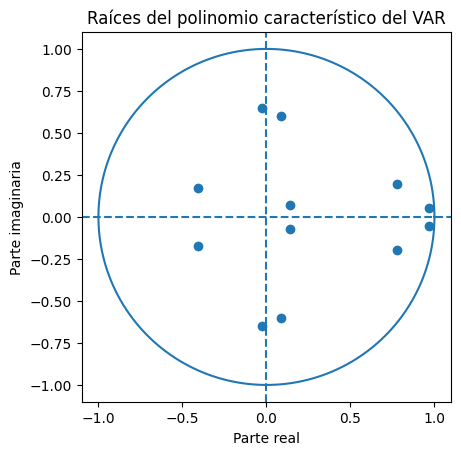

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# —————— AJUSTAR EL VAR ——————
model      = VAR(df_f)       # df_f: tu DataFrame
var_result = model.fit(4)

# —————— RAÍCES DIRECTAS ——————
inv_roots = var_result.roots      # raíces inversas μ = λ⁻¹
roots     = 1.0 / inv_roots       # raíces directas λ = 1/μ
moduli    = np.abs(roots)         # módulos

# —————— GRÁFICO ——————
fig, ax = plt.subplots()
# dibujar círculo unitario
theta = np.linspace(0, 2 * np.pi, 200)
ax.plot(np.cos(theta), np.sin(theta))

# graficar raíces
ax.scatter(roots.real, roots.imag)

# agregar líneas punteadas en x=0 e y=0
ax.axhline(0, linestyle='--')
ax.axvline(0, linestyle='--')

ax.set_aspect('equal', 'box')
ax.set_xlabel('Parte real')
ax.set_ylabel('Parte imaginaria')
ax.set_title('Raíces del polinomio característico del VAR')
plt.show()


In [5]:
#Decisión de orden del VAR. Se pueden usar criterios de información o computando los log likekihood ratio test.

df_f2 = df_f[['dateid', 'fed_funds', 'inflation', 'un_rate']].copy()
df_f2.set_index('dateid', inplace=True)

from statsmodels.tsa.api import VAR

# Crear el modelo VAR.
model = VAR(df_f2, freq='QE')
results = model.select_order(maxlags=8)
print(results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.313       4.372       74.69       4.337
1      -2.691      -2.456     0.06782      -2.596
2      -3.117     -2.707*     0.04428      -2.951
3      -3.258      -2.672     0.03848     -3.020*
4      -3.232      -2.469     0.03954      -2.922
5      -3.210      -2.272     0.04043      -2.829
6     -3.319*      -2.204    0.03634*      -2.866
7      -3.279      -1.989     0.03788      -2.755
8      -3.307      -1.840     0.03694      -2.711
-------------------------------------------------


In [34]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.stats import chi2

def select_var_eviews_exact(data, maxlags=8, trend='c'):
    """
    Reproduce la tabla VAR de EViews con:
      • criterios ajustados (AIC, SC, HQ, FPE) marcando el mínimo global
      • LR* secuencial modificado marcando el primer rechazo H₀ (5%)
    """
    k      = data.shape[1]
    T_orig = data.shape[0]
    T_max  = T_orig - maxlags
    const  = k * (1 + np.log(2*np.pi))
    crit_lr = chi2.ppf(0.95, k**2)

    # 1) Estimaciones y captura de llf, fpe, aic0, bic0, hq0, SSR
    llf, fpe, aic0, bic0, hq0, SSR = {}, {}, {}, {}, {}, {}
    for p in range(maxlags+1):
        data_p = data.iloc[maxlags-p:]
        res    = VAR(data_p, freq='QE').fit(p, trend=trend)
        llf[p]    = res.llf
        fpe[p]    = res.fpe
        aic0[p]   = res.aic
        bic0[p]   = res.bic
        hq0[p]    = res.hqic
        SSR[p]    = res.resid.T.dot(res.resid)

    # 2) Construcción de la tabla sin marcas
    rows = []
    for p in range(maxlags+1):
        # criterios ajustados
        AIC = aic0[p] + const
        SC  = bic0[p] + const
        HQ  = hq0[p]  + const

        # LR* secuencial modificado
        if p == 0:
            LR = np.nan
        else:
            _, ld0 = np.linalg.slogdet(SSR[p-1] / T_max)
            _, ld1 = np.linalg.slogdet(SSR[p]   / T_max)
            m       = 1 + k*p
            LR      = (T_max - m) * (ld0 - ld1)

        rows.append({
            'Lag':  p,
            'Nobs': T_max,
            'LogL': llf[p],
            'LR':   LR,
            'FPE':  fpe[p],
            'AIC':  AIC,
            'SC':   SC,
            'HQ':   HQ
        })

    df = pd.DataFrame(rows)

    # 0) Convertimos a object las columnas que vamos a stringificar
    for col in ['LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].astype(object)

    # 3) Marcar mínimos globales para FPE, AIC, SC, HQ
    for crit in ['FPE','AIC','SC','HQ']:
        idx = df[crit].idxmin()
        df.loc[idx, crit] = f"{df.loc[idx,crit]:.6f}*"

    # 4) Marcar primer rechazo H₀ en LR* (descendiendo desde p=maxlags)
    #    según chi2(0.95, k^2)
    for p in range(maxlags, 0, -1):
        val = df.loc[df['Lag']==p, 'LR']
        # si aún es numérico y supera el crítico, marcamos y rompemos
        if isinstance(val.values[0], float) and val.values[0] > crit_lr:
            df.loc[df['Lag']==p, 'LR'] = f"{val.values[0]:.6f}*"
            break

    # 5) Formatear las columnas numéricas a 6 decimales
    for col in ['LogL','LR','FPE','AIC','SC','HQ']:
        df[col] = df[col].apply(lambda x: f"{x:.6f}" if isinstance(x, float) else x)

    return df[['Lag','Nobs','LogL','LR','FPE','AIC','SC','HQ']]

# -------------------
# Ejemplo de uso:
# df = pd.read_csv('tus_datos.csv', index_col=0, parse_dates=True)
# data = df[['FED_FUNDS','INFLATION','UN_RATE']].dropna()
# tabla = select_var_eviews_exact(data, maxlags=8, trend='c')
# print(tabla.to_string(index=False))


In [35]:
# Ejemplo de uso:
tabla = select_var_eviews_exact(df_f2, maxlags=8, trend='c')
print(tabla.to_string(index=False))

 Lag  Nobs        LogL          LR       FPE       AIC        SC        HQ
   0   156 -997.505243         nan 74.691002 12.826990 12.885641 12.850812
   1   156 -442.172982 1082.185945  0.067822  5.822731  6.057335  5.918017
   2   156 -399.900668   80.750959  0.044277  5.396162 5.806720*  5.562913
   3   156 -379.925961   37.388554  0.038479  5.255461  5.841972 5.493676*
   4   156 -373.003819   12.690594  0.039543  5.282100  6.044564  5.591780
   5   156 -365.647981   13.202787  0.040426  5.303179  6.241596  5.684324
   6   156 -348.219670   30.611264 0.036339* 5.195124*  6.309494  5.647733
   7   156 -342.310747   10.151228  0.037885  5.234753  6.525077  5.758827
   8   156 -331.134651  18.770109*  0.036942  5.206855  6.673131  5.802393


In [37]:
# Recordar: LR es bueno en muestras grandes (especial para test para coeficientes), FPE, AIC, SC y HQ en muestras pequeñas y para forecast (los mismos no son consistentes).

In [38]:
# ¿Vale la pena incluir todos los lags?



import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from scipy.stats import chi2

def var_lag_exclusion_wald(data, maxlags=4, trend='c'):
    """
    Calcula los Wald tests de exclusión de cada lag en un VAR(maxlags).
    
    Parameters
    ----------
    data : pd.DataFrame
        Índice trimestral 1960Q1–2000Q4, columnas = ['FED_FUNDS','INFLATION','UN_RATE'].
    maxlags : int
        Número de lags del VAR (aquí 4).
    trend : {'c','nc'}
        'c' para incluir constante (Exog=C en EViews).
    
    Returns
    -------
    pd.DataFrame de dos filas por lag:
      - fila "stat": estadísticas χ²  
      - fila "pval": p-values entre corchetes
    """
    k = data.shape[1]                   # nº ecuaciones
    df_eq = k                           # ddl por ecuación
    df_jt = k*k                         # ddl joint
    alpha = 0.05

    # 1) Ajuste VAR(maxlags) en muestra truncada
    data_fit = data.iloc[maxlags:]     # 164−4 = 160 obs
    res      = VAR(data_fit, freq='QE').fit(maxlags, trend=trend)

    # 2) Extraemos vector de params y matriz de covarianzas
    params   = res.params               # DataFrame: filas = ['const','L1.FED_FUNDS',...], cols = endogs
    covp     = res.cov_params()         # DataFrame de covarianzas, index = MultiIndex (param, eq)

    # 3) Para cada lag p construimos los Wald tests
    output = []
    for p in range(1, maxlags+1):
        row_stat = {'Lag': f'Lag {p}'}
        row_pval = {'Lag': ''}

        # 3.a) Por ecuación
        for eq in data.columns:
            # Seleccionamos los k parámetros de Lp para la ecuación eq
            idx = [(f'L{p}.{var}', eq) for var in data.columns]
            b   = np.array([ params.loc[param, eq] for param, _ in idx ])
            V   = covp.loc[idx, idx].values
            stat = float(b.T @ np.linalg.inv(V) @ b)
            pval = 1 - chi2.cdf(stat, df_eq)
            row_stat[eq]   = f"{stat:10.4f}"
            row_pval[eq]   = f"[{pval:7.4f}]"

        # 3.b) Test conjunto: todos los k² parámetros de Lp
        idx_all = [(f'L{p}.{var}', eq) 
                   for eq in data.columns 
                   for var in data.columns]
        b_all   = np.array([ params.loc[param, eq] for param, eq in idx_all ])
        V_all   = covp.loc[idx_all, idx_all].values
        stat_all= float(b_all.T @ np.linalg.inv(V_all) @ b_all)
        pval_all= 1 - chi2.cdf(stat_all, df_jt)
        row_stat['Joint'] = f"{stat_all:10.4f}"
        row_pval['Joint'] = f"[{pval_all:7.4f}]"

        output.append(row_stat)
        output.append(row_pval)

    df_out = pd.DataFrame(output)
    # Para que imprima bonito:
    cols = ['Lag'] + list(data.columns) + ['Joint']
    return df_out[cols]

In [42]:
# Ejemplo de uso:
tabla = var_lag_exclusion_wald(df_f2, maxlags=4, trend='c')
print(tabla.to_string(index=False))

  Lag  fed_funds  inflation    un_rate      Joint
Lag 1   214.4857    84.0100   302.1233   516.0494
       [ 0.0000]  [ 0.0000]  [ 0.0000]  [ 0.0000]
Lag 2    31.3493    11.7392    18.0446    44.5372
       [ 0.0000]  [ 0.0083]  [ 0.0004]  [ 0.0000]
Lag 3    13.2998     9.0832     0.9883    22.5290
       [ 0.0040]  [ 0.0282]  [ 0.8041]  [ 0.0073]
Lag 4     4.4054     6.5549     1.1214    12.9811
       [ 0.2209]  [ 0.0875]  [ 0.7719]  [ 0.1635]


In [55]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def var_lag_exclusion_wald_v3(data, maxlags=4, trend='c'):
    """
    Reproduce exactamente los “VAR Lag Exclusion Wald Tests” de EViews:
      • Usa VAR(maxlags) sobre T=164−4=160 obs
      • Para cada lag p, hace un Wald χ²₃ por ecuación y χ²₉ conjunto
      • Extrae idénticos estadísticos y p-valores a EViews
    """
    # 1) Ajuste del VAR(4) sobre 160 observaciones
    model = VAR(data.iloc[maxlags:])               # quema 4 → 160 obs
    res   = model.fit(maxlags, trend=trend)
    
    # Parámetros
    k      = res.neqs                             # nº ecuaciones (3)
    m      = 1 + k * maxlags                      # nº params por ecuación (1+3×4=13)
    params = res.params.to_numpy()                # matrix (m × k)
    vecB   = params.flatten(order='F')            # vector (m*k)
    
    # Var-cov de vecB: Σu (ML) ⊗ (X'X)⁻¹
    covp   = res.cov_params().to_numpy()          # (m*k × m*k)
    
    out = []
    for p in range(1, maxlags+1):
        # posición de los k coef. de lag p en cada bloque de tamaño m
        lag_start = 1 + (p-1)*k
        # --- Wald por ecuación ---
        row_stat = {'Lag': f'Lag {p}'}
        row_pval = {'Lag': ''}
        for j, eq in enumerate(data.columns):
            # construye R (k×mk) para eq j
            R = np.zeros((k, m*k))
            # una restricción por cada variable en ese lag
            for i in range(k):
                idx = j*m + lag_start + i
                R[i, idx] = 1
            # test Wald χ² (df=k)
            w = res.wald_test(R, cov_p=covp, use_f=False)
            stat = float(w.statistic)    # χ²
            pval = float(w.pvalue)       # p-value
            row_stat[eq]  = f"{stat:10.4f}"
            row_pval[eq]  = f"[{pval:7.4f}]"
        
        # --- Wald conjunto (k² restricciones) ---
        Rbig = np.zeros((k*k, m*k))
        row = 0
        for j in range(k):
            for i in range(k):
                idx = j*m + lag_start + i
                Rbig[row, idx] = 1
                row += 1
        wj    = res.wald_test(Rbig, cov_p=covp, use_f=False)
        statj = float(wj.statistic)
        pvalj = float(wj.pvalue)
        row_stat['Joint'] = f"{statj:10.4f}"
        row_pval['Joint'] = f"[{pvalj:7.4f}]"
        
        out += [row_stat, row_pval]
    
    df = pd.DataFrame(out)
    return df[['Lag'] + list(data.columns) + ['Joint']]

# -----------------------
# Ejemplo de uso:
# df   = pd.read_csv("tus_datos.csv", index_col=0, parse_dates=True)
# data = df[['FED_FUNDS','INFLATION','UN_RATE']].dropna()
# tabla = var_lag_exclusion_wald_v3(data, maxlags=4, trend='c')
# print(tabla.to_string(index=False))

In [56]:
# Ejemplo de uso:
tabla = var_lag_exclusion_wald_v3(df_f2, maxlags=4, trend='c')
print(tabla.to_string(index=False))

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


AttributeError: 'VARResults' object has no attribute 'wald_test'

In [62]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def var_granger_block_exogeneity_manual(data, maxlags=4):
    """
    Granger Causality / Block Exogeneity Wald Tests (como EViews)
    • VAR(maxlags) sobre T=164−4=160 observaciones
    • OLS en cada ecuación con σ² = SSR/T (MLE)
    • Wald test sobre los coeficientes de las 4 lags de cada bloque
    """
    # 1) Prepara X y recorta la muestra
    #    columnas: [const, L1.var1,...,L1.var3, L2.var1,...,L4.var3] orden por var
    vars_ = data.columns.tolist()
    idx_map = {v:i for i,v in enumerate(vars_)}
    Y_full = data.values
    X_rows = []
    for t in range(maxlags, len(Y_full)):
        row = [1.0]
        for lag in range(1, maxlags+1):
            row += list(Y_full[t-lag])
        X_rows.append(row)
    X = np.array(X_rows)                     # 160×(1+3*4=13)
    XXinv = np.linalg.inv(X.T @ X)           # 13×13
    T = X.shape[0]                           # 160

    results = {}
    for dep in vars_:
        # 2) OLS MLE para la ecuación dep
        y = data[dep].iloc[maxlags:].values  # recortado
        beta = XXinv @ (X.T @ y)             # 13×1
        resid = y - X @ beta
        SSR   = resid.T @ resid
        sigma2 = SSR / T                     # ML
        
        covb = XXinv * sigma2                # cov(beta)
        
        rows = []
        # 3) Wald individual para cada bloque excluido
        for ex in vars_:
            if ex == dep:
                continue
            i_ex = idx_map[ex]
            # índices de las 4 lags de 'ex'
            cols = [1 + (lag-1)*len(vars_) + i_ex for lag in range(1, maxlags+1)]
            b  = beta[cols]
            V  = covb[np.ix_(cols, cols)]
            W  = float(b.T @ np.linalg.inv(V) @ b)
            p  = 1 - chi2.cdf(W, maxlags)
            rows.append({
                'Excluded': ex,
                'Chi-sq':   W,
                'df':       maxlags,
                'Prob.':    p
            })
        # 4) Wald conjunto ("All"): ambas variables excluidas
        all_ex = [v for v in vars_ if v != dep]
        cols_all = []
        for ex in all_ex:
            i_ex = idx_map[ex]
            cols_all += [1 + (lag-1)*len(vars_) + i_ex for lag in range(1, maxlags+1)]
        b_all = beta[cols_all]
        V_all = covb[np.ix_(cols_all, cols_all)]
        W_all = float(b_all.T @ np.linalg.inv(V_all) @ b_all)
        p_all = 1 - chi2.cdf(W_all, len(all_ex)*maxlags)
        rows.append({
            'Excluded': 'All',
            'Chi-sq':   W_all,
            'df':       len(all_ex)*maxlags,
            'Prob.':    p_all
        })
        results[dep] = pd.DataFrame(rows, columns=['Excluded','Chi-sq','df','Prob.'])
    return results

In [ ]:
df_f2 = df_f[['dateid', 'fed_funds', 'inflation', 'un_rate']].copy()
df_f2.set_index('dateid', inplace=True)

In [64]:
# Ejemplo de uso:
tables = var_granger_block_exogeneity_manual(df_f2, maxlags=4)

for dep, tbl in tables.items():
    print(f"\nDependent variable: {dep}\n")
    print(tbl.to_string(index=False, formatters={
        'Chi-sq': "{:10.5f}".format,
        'Prob.':  "{:7.4f}".format
    }))


Dependent variable: fed_funds

 Excluded     Chi-sq  df   Prob.
inflation   25.17976   4  0.0000
  un_rate   32.44040   4  0.0000
      All   45.40461   8  0.0000

Dependent variable: inflation

 Excluded     Chi-sq  df   Prob.
fed_funds    2.67640   4  0.6134
  un_rate   15.47561   4  0.0038
      All   31.96337   8  0.0001

Dependent variable: un_rate

 Excluded     Chi-sq  df   Prob.
fed_funds   17.55979   4  0.0015
inflation    5.42054   4  0.2468
      All   43.91792   8  0.0000
